<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/updating/7_model_training_RRDB_enhanced_data_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use T4 GPU. It is possible to run all other sections at a slower rate on CPU.

Note: The code below has been configured to run on Google colab with python scripts and data imported from google drive. Please download the scripts and data from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h1> 7. Machine Learning on ESR-GAN Enhanced Images using CNN</h1>

Based on Notebook 2 [Training data preparation using RRDB](https://github.com/Jieoi/traffic_sign_recognition/blob/main/2_train_data_preparation_RRDB.ipynb), this notebook is used to train a CNN model on the enhanced training data.

The testing data is also loaded to evaluate the models as they are being developed.

The testing data is from Notebook 3 [Testing data preparation using simple technic](https://github.com/Jieoi/traffic_sign_recognition/blob/main/4_test_data_preparation_RRDB.ipynb).

There is **no need to run the notebooks named above**, a copy of the prepared data is saved in the Google drive which will be loaded in 7.1.1.

<h2> 7.1 Data Preparation for Machine Learning</h2>

Firstly, the data that were enhanced and augmented were loaded from the Google drive. As this colab instance is configured to use T4 GPU, some configuration checks are conducted to ensure the GPU is available. Libraries that are needed for machine learning were also imported.

<h2>7.1 Preparing the notebook</h2>

The first step is to connect to Google Drive so that the data enhanced in the previouse notebook can be used.

The exact files that the notebook needs to  access are <code>image_enhanced_PIL_RRDB.zip</code> and <code>image_dataRRDB.csv</code>.
They can be found in the train_data and test_data folders <a href="https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8">here</a>.


Ideally, the notebook should be run in Google Colab with high RAM and GPU support. However, the code can be excuted on CPU only mode with a longer training time.

In [ ]:
# Checking GPU availability
!nvidia-smi

Sat Sep  9 12:17:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The output shows that the GPU is available.

Google drive is also mounted to this colab instance. Data is then extracted from the zip file.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('drive', force_remount=True)

Mounted at drive


The libraries used in this notebook are listed below.

In [ ]:
# Zip file handling
import zipfile
import os

# Data handling and visualization
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File handling and management for training and validation data
from shutil import copyfile
from sklearn.model_selection import train_test_split

# importing library for ML processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Regularization
from tensorflow.keras import regularizers

# Saving the model
from tensorflow.keras.models import save_model

# Metrics for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

<h2>7.1.2 Data preparation for Machine Learning</h2>

Firstly, pre-porcessed training data is obtained and prepared for machine learning:


Then the images are extracted from the <code>image_enhanced_PIL_RRDB.zip</code> file. It is first extracted in the code below.

In [ ]:
# Paths
zip_file_path = 'drive/MyDrive/final/train_data/image_enhanced_PIL_RRDB.zip'
extracted_dir = 'extracted_images'

# Create the directory for extracted images if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)


# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Check the length of the extracted images
num_extracted_images = len(os.listdir(extracted_dir))
print(f"Number of extracted images: {num_extracted_images}")
print("Extraction completed.")

Number of extracted images: 26660
Extraction completed.


Then the labels for all the images is in the <code>image_dataRRDB.csv</code> file.

In [ ]:
# Define the directory where the images are extracted
extracted_dir = 'extracted_images'

# Get a list of all extracted image files
image_files = os.listdir(extracted_dir)

# Initialize lists to store image names and label numbers
image_names = []
label_numbers = []

# Loop through the image files and extract image names and label numbers
for image_file in image_files:
    if image_file.endswith('.png'):
        # Split the image file name to extract label number
        parts = image_file.split('_')
        if len(parts) >= 3:
            label_number = int(parts[-1].split('.')[0])  # Extract the label number
            image_names.append(image_file)
            label_numbers.append(label_number)

# Create a pandas DataFrame
data = {'filename': image_names, 'class': label_numbers}
df_classes = pd.DataFrame(data)

# Print the first few rows of the DataFrame
df_classes.head()

,filename,class
0,image_23125_label_30.png,30
1,image_887_label_3.png,3
2,image_1006_label_10.png,10
3,image_13641_label_12.png,12
4,image_14748_label_17.png,17


Both images and there labels extracted contains the same number of entries.

The distribution of the final classes is shown below.

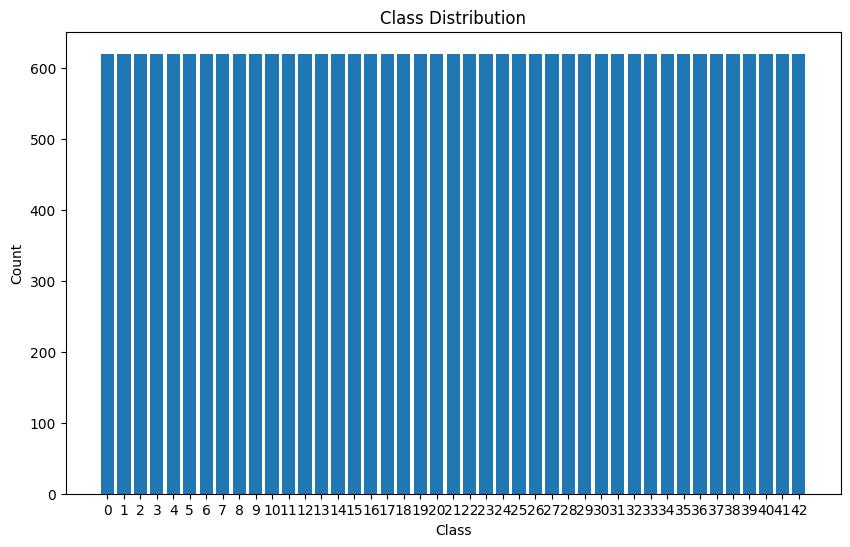

In [ ]:
# Count the occurrences of each class in the DataFrame
class_counts = df_classes['class'].value_counts()

# Sort the unique class IDs
unique_classes = np.sort(df_classes['class'].unique())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts[unique_classes])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

This shows that the images were equally distributed among the classes as what has being prepared in the previous notebook.

Both images are first split into training and validation sets. They are grouped by their classes and stored in individual directories for every classes.

In [ ]:
train_dir = 'train_images'
valid_dir = 'valid_images'

# Create directories for training and validation images
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df_classes, test_size=0.2, random_state=42, stratify=df_classes['class'])

# Copy images to directories based on classes for training set
for index, row in train_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(train_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

# Copy images to directories based on classes for validation set
for index, row in valid_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(valid_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

print("Data preparation for ML completed.")

Data preparation for ML completed.


<h1> 7.2 Machine Learning</h1>

<h2>7.2.1 Data pipeline</h2>

<code>flow_from_directory()</code> from Keras ImageDataGenerator is used to load the images with rescaling to 1/255. batch size and image size are pre-set to 32 and (128, 128), respectively. These number were based on the upscaling of images in image enhancement.

In [ ]:
# Define image dimensions and batch size
image_size = (128,128)
batch_size = 32

# Create data generators and rescale image for ML on training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=True  # Set shuffle to True for training data
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=False  # Set shuffle to False for validation data
)

# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

Found 21328 images belonging to 43 classes.
Found 5332 images belonging to 43 classes.


Total <b>21328</b> images are loaded into the training data and <b>5332</b> images are loaded into the validation data.

Next, the test data is also obtained and prepared for machine learning.

Firstly, the class labels are extracted from the <code>test_image_enhanced_PIL_RRDB.zip</code> file. As in the preparation of the testing data, the class labels were saved directly into the filenames of each images

In [ ]:
# Define a function to extract the class label from the image file name
def extract_label(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        return parts[-2]  # Extract the label number
    else:
        return None

In [ ]:
# Define the paths
test_zip_path = 'drive/MyDrive/final/test_data/test_images_enhanced_PIL_RRDB.zip'
test_extracted_dir = 'extracted_test_images'
test_dir = 'test_images'

# Create the directory for extracted test images if it doesn't exist
os.makedirs(test_extracted_dir, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extracted_dir)

In [ ]:
# List all files in the extracted directory
test_image_files = os.listdir(test_extracted_dir)

# Create subdirectories based on class labels and move images
for filename in test_image_files:
    if filename.endswith('.png'):
        label = extract_label(filename)
        if label is not None:
            class_dir = os.path.join(test_dir, label)
            os.makedirs(class_dir, exist_ok=True)
            src_path = os.path.join(test_extracted_dir, filename)
            dst_path = os.path.join(class_dir, filename)
            copyfile(src_path, dst_path) # shutil

Data generator is used for loading images into the model.

In [ ]:
# Create a data generator for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=False  # Set shuffle to False for testing data
)

Found 12599 images belonging to 43 classes.


<h2>2.2.2 Training the CNN model</h2>

Double checking the GPU availability and set the GPU device if it is available

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Specify GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


A function is defined to plot the training history and calculate the changes in accuracy and loss.

In [ ]:
def calculate_accuracy_increase_rate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_rate = np.mean(np.diff(train_accuracy))
    val_rate = np.mean(np.diff(val_accuracy))

    return train_rate, val_rate

In [ ]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

Then, true labels are extracted from the test generator for testing later.

In [ ]:
# Get true labels from the test generator
true_labels = test_generator.classes

# Get unique true labels
class_names = [str(label) for label in range(43)]

The model development will start from developing a simple model that serves as a baseline in this development cycle. It is different from the basline of the whole project as this is trained on enhanced and augmented data.

<h2> Model 1: Simple CNN baseline</h2>


As there are many models being developed for this project, a final check is conducted on the input images.

In [ ]:
# Get the first batch
images, labels = next(train_generator)

# Check the shape of the first image in the batch
shape_of_first_image = images[0].shape

# Print the shape
print("Shape of the first training image:", shape_of_first_image)


Shape of the first training image: (128, 128, 1)


Training the CNN model to upto 30 epochs, early stopping is used to prevent overfitting. However, no regularization is applied.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(128, 128, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_CNN = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

A simple summary of the model is displayed:

In [ ]:
model_CNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

The model is trained with the early stopping callback

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 30
history_simpleCNN = model_CNN.fit(train_generator,
                                  epochs=num_epochs,
                                  validation_data=valid_generator,
                                  callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
667/667 [==============================] - 58s 69ms/step - loss: 2.5456 - accuracy: 0.3035 - val_loss: 0.9670 - val_accuracy: 0.7470
Epoch 2/30
667/667 [==============================] - 44s 67ms/step - loss: 1.1430 - accuracy: 0.6386 - val_loss: 0.5572 - val_accuracy: 0.8423
Epoch 3/30
667/667 [==============================] - 51s 77ms/step - loss: 0.8366 - accuracy: 0.7268 - val_loss: 0.3211 - val_accuracy: 0.9107
Epoch 4/30
667/667 [==============================] - 46s 69ms/step - loss: 0.6641 - accuracy: 0.7805 - val_loss: 0.2806 - val_accuracy: 0.9239
Epoch 5/30
667/667 [==============================] - 45s 67ms/step - loss: 0.5591 - accuracy: 0.8127 - val_loss: 0.2368 - val_accuracy: 0.9366
Epoch 6/30
667/667 [==============================] - 48s 71ms/step - loss: 0.4842 - accuracy: 0.8340 - val_loss: 0.2256 - val_accuracy: 0.9389
Epoch 7/30
667/667 [==============================] - 46s 69ms/step - loss: 0.4234 - accuracy: 0.8540 - val_loss: 0.1854 - val_accuracy:

The training stopped at <b>epoch 17</b> as the model started overfitting (shown by the validation loss). The training accuracy and validation accuracy graph are shown below.

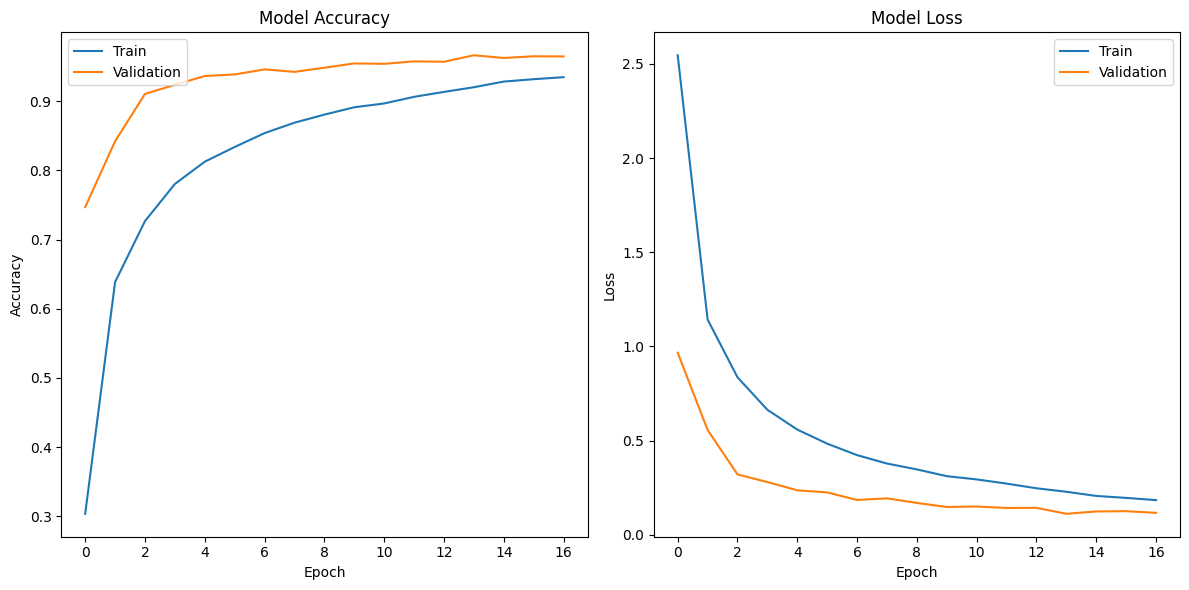

In [ ]:
plot_training_history(history_simpleCNN)

This model has a lower training accuracy than validation accuracy. And the validaton accuracy is continuesly increasing, indicating no signs of overfitting.

In [ ]:
# Increasing rate
train_rate_SCNN, val_rate_SCNN = calculate_accuracy_increase_rate(history_simpleCNN)
print("Training Accuracy Increase Rate:", train_rate_SCNN)
print("Validation Accuracy Increase Rate:", val_rate_SCNN)

Training Accuracy Increase Rate: 0.039463965222239494
Validation Accuracy Increase Rate: 0.013620592653751373


The rate of increase for accuracy is calculated

Then, the model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_SCNN, test_accuracy_SCNN = model_CNN.evaluate(test_generator)

print(f"Test Loss: {test_loss_SCNN:.4f}")
print(f"Test Accuracy: {test_accuracy_SCNN:.4f}")

394/394 [==============================] - 17s 42ms/step - loss: 0.4554 - accuracy: 0.8828
Test Loss: 0.4554
Test Accuracy: 0.8828


In [ ]:
# Make predictions on the test data
test_pred_SCNN = model_CNN.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
pred_labels_SCNN = np.argmax(test_pred_SCNN, axis=1)

# Calculate the precision score
precision_SCNN = precision_score(true_labels, pred_labels_SCNN, average='weighted')

print(f"Precision Score: {precision_SCNN:.4f}")

394/394 [==============================] - 16s 41ms/step
Precision Score: 0.8894


In [ ]:
# Generate a classification report
class_rep_SCNN = classification_report(true_labels, pred_labels_SCNN, target_names=class_names)

print("Classification Report:\n", class_rep_SCNN)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91       293
           1       0.95      0.95      0.95       293
           2       0.98      0.99      0.99       293
           3       0.96      0.92      0.94       293
           4       0.95      0.99      0.97       293
           5       0.98      0.97      0.97       293
           6       0.99      0.95      0.97       293
           7       0.95      0.98      0.97       293
           8       0.98      0.99      0.98       293
           9       0.97      0.97      0.97       293
          10       0.96      0.95      0.95       293
          11       0.69      0.88      0.77       293
          12       0.94      0.96      0.95       293
          13       0.62      0.77      0.69       293
          14       0.86      0.68      0.76       293
          15       0.91      0.89      0.90       293
          16       0.70      0.65      0.67       293
   

Generally, the model is performing well with a test precision of 88.94% and test accuracy of 88.28%. For acciracy across all classes, the worst performing one is class 13 with 62% precision and 69% F1 score. It is also noticed that some classes have perfect scores on precision.

Comparing across different models, this simple CNN model is performing better than the baseline model on CNN and better than the [simple CNN model with simple data enhancement](https://github.com/Jieoi/traffic_sign_recognition/blob/main/5_model_training_simple_enhanced_data_CNN.ipynb)

<h2> Model 2: More complex CNN with regularization</h2>



More complexity is added to the CNN model with regularization added:

*   Added more convolutional layers with increasing filters to capture more complex features

*   Added batch normalization layers after each convolutional and dense layer to help stabilize training. (Recommended in chapter 7.3.1 Advanced architechtures in Deep Learning with Python, Francois Chollet)

*   Added an additional dense layer with dropout and batch normalization.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(128, 128, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_complex = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_complex.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

A summary of the model is displayed:

In [ ]:
model_complex.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 128)       512 

The model is trained with the early stopping callback monitering the validation loss:

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation and early stopping
num_epochs = 50
history_complex_model = model_complex.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 54s 74ms/step - loss: 12.7306 - accuracy: 0.5007 - val_loss: 9.1253 - val_accuracy: 0.7991
Epoch 2/50
667/667 [==============================] - 51s 76ms/step - loss: 7.5437 - accuracy: 0.7641 - val_loss: 5.7601 - val_accuracy: 0.8599
Epoch 3/50
667/667 [==============================] - 52s 78ms/step - loss: 4.9686 - accuracy: 0.8284 - val_loss: 4.0559 - val_accuracy: 0.8863
Epoch 4/50
667/667 [==============================] - 49s 73ms/step - loss: 3.5973 - accuracy: 0.8734 - val_loss: 3.0531 - val_accuracy: 0.9177
Epoch 5/50
667/667 [==============================] - 51s 76ms/step - loss: 2.8198 - accuracy: 0.8988 - val_loss: 2.4893 - val_accuracy: 0.9385
Epoch 6/50
667/667 [==============================] - 49s 74ms/step - loss: 2.3713 - accuracy: 0.9214 - val_loss: 2.1801 - val_accuracy: 0.9430
Epoch 7/50
667/667 [==============================] - 51s 76ms/step - loss: 2.0683 - accuracy: 0.9395 - val_loss: 1.9408 - val_accuracy

The training stopped at <b>epoch 16</b> as the model started overfitting (shown by the validation loss). This happend <b>1 epoch</b> before the previous model. The training accuracy and validation accuracy graph are shown below.

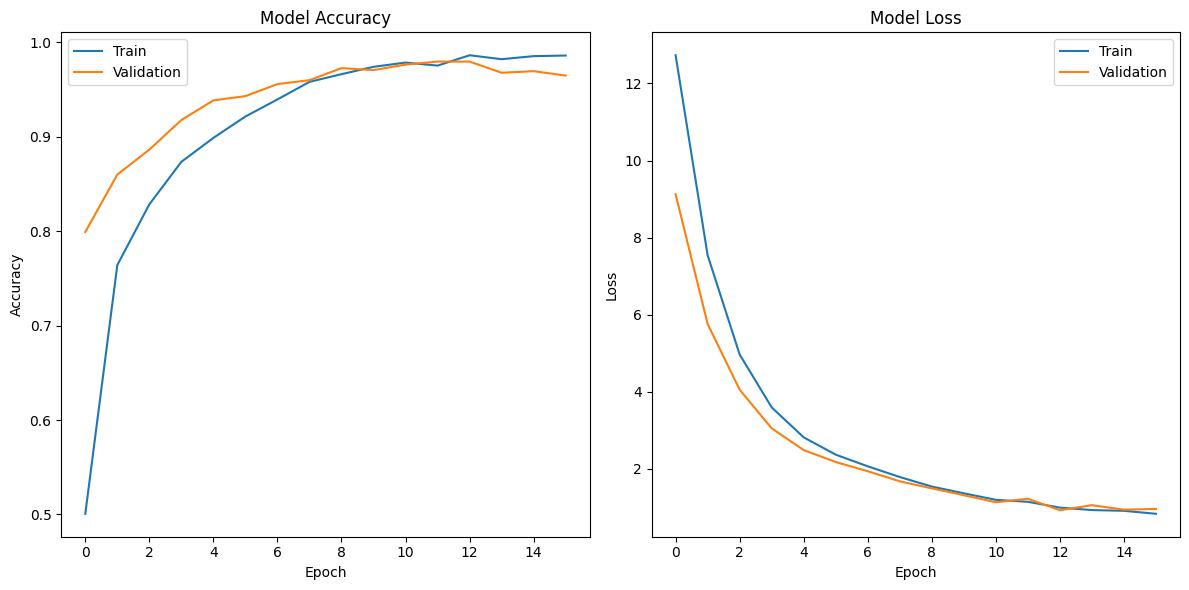

In [ ]:
plot_training_history(history_complex_model)

This model has a lower training accuracy than validation accuracy until about <b>epoch 10</b>. And the validaton accuracy is continuesly increasing, indicating no signs of overfitting.

In [ ]:
# Increasing rate
train_rate_complex, val_rate_complex = calculate_accuracy_increase_rate(history_complex_model)
print("Training Accuracy Increase Rate:", train_rate_complex)
print("Validation Accuracy Increase Rate:", val_rate_complex)

Training Accuracy Increase Rate: 0.03235183954238892
Validation Accuracy Increase Rate: 0.011040258407592773


The rate of increase for accuracy is calculated above. It is increasing at a **slower rate** than the simple CNN model.

Then, the model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_complex, test_accuracy_complex = model_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_complex:.4f}")
print(f"Test Accuracy: {test_accuracy_complex:.4f}")

394/394 [==============================] - 19s 49ms/step - loss: 1.2031 - accuracy: 0.9075
Test Loss: 1.2031
Test Accuracy: 0.9075


In [ ]:
# Make predictions on the test data
test_pred_complex = model_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_complex = np.argmax(test_pred_complex, axis=1)

# Calculate the precision score
precision_complex = precision_score(true_labels, predicted_labels_complex, average='weighted')

print(f"Precision Score: {precision_complex:.4f}")

394/394 [==============================] - 17s 44ms/step
Precision Score: 0.9123


In [ ]:
# Generate a classification report
class_rep_complex = classification_report(true_labels, predicted_labels_complex, target_names=class_names)

print("Classification Report:\n", class_rep_complex)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       293
           1       0.98      0.88      0.93       293
           2       1.00      0.98      0.99       293
           3       0.97      0.95      0.96       293
           4       0.97      0.99      0.98       293
           5       0.99      1.00      0.99       293
           6       0.99      0.95      0.97       293
           7       1.00      0.95      0.97       293
           8       0.98      0.97      0.98       293
           9       1.00      0.97      0.99       293
          10       0.94      0.89      0.92       293
          11       0.85      0.92      0.89       293
          12       0.87      0.98      0.92       293
          13       0.74      0.91      0.82       293
          14       0.86      0.90      0.88       293
          15       0.95      0.83      0.89       293
          16       0.85      0.83      0.84       293
   

Generally, the model is performing well with a test precision of 90.07% and test accuracy of 91.23%. For accuracy across all classes, the worst performing one is class 31 with 71% precision and 71% F1 score. It is also noticed that a few classes have perfect scores on precision.

This model improved the performance of the simple CNN model especially on the accuracy across all classes on test data.

<h2> Model 3: Even more complex CNN with learning rate adjustment</h2>

An attempt has been made to add more layers to the model with a **lower learning rate**. It could potentially allow a **more complexed model** with less likelihood of overfitting, at a cost of **increased training time**.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(128, 128, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
# Create the model
model_more_complex = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_more_complex.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_more_complex.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 64)      640       
                                                                 
 batch_normalization_6 (Bat  (None, 126, 126, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_7 (Bat  (None, 61, 61, 128)       512 

In [ ]:
# Compile the model with a lower learning rate
model_more_complex.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 50
history_more_complex_model = model_more_complex.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 75s 109ms/step - loss: 6.0313 - accuracy: 0.7944 - val_loss: 4.5161 - val_accuracy: 0.8953
Epoch 2/50
667/667 [==============================] - 51s 77ms/step - loss: 3.9717 - accuracy: 0.8621 - val_loss: 3.1690 - val_accuracy: 0.9128
Epoch 3/50
667/667 [==============================] - 51s 76ms/step - loss: 2.8346 - accuracy: 0.9036 - val_loss: 2.3680 - val_accuracy: 0.9407
Epoch 4/50
667/667 [==============================] - 51s 76ms/step - loss: 2.1573 - accuracy: 0.9232 - val_loss: 1.8324 - val_accuracy: 0.9539
Epoch 5/50
667/667 [==============================] - 51s 76ms/step - loss: 1.6712 - accuracy: 0.9373 - val_loss: 1.4418 - val_accuracy: 0.9586
Epoch 6/50
667/667 [==============================] - 51s 76ms/step - loss: 1.3275 - accuracy: 0.9496 - val_loss: 1.1919 - val_accuracy: 0.9604
Epoch 7/50
667/667 [==============================] - 53s 80ms/step - loss: 1.0859 - accuracy: 0.9556 - val_loss: 0.9677 - val_accuracy

The training stopped at **epoch 24** as the model started overfitting (shown by the validation loss). This happend 8 epoch after the previous model. The training accuracy and validation accuracy graph are shown below. It was noted that the **training accuracy** and the **validation accuracy** are both **very high**.

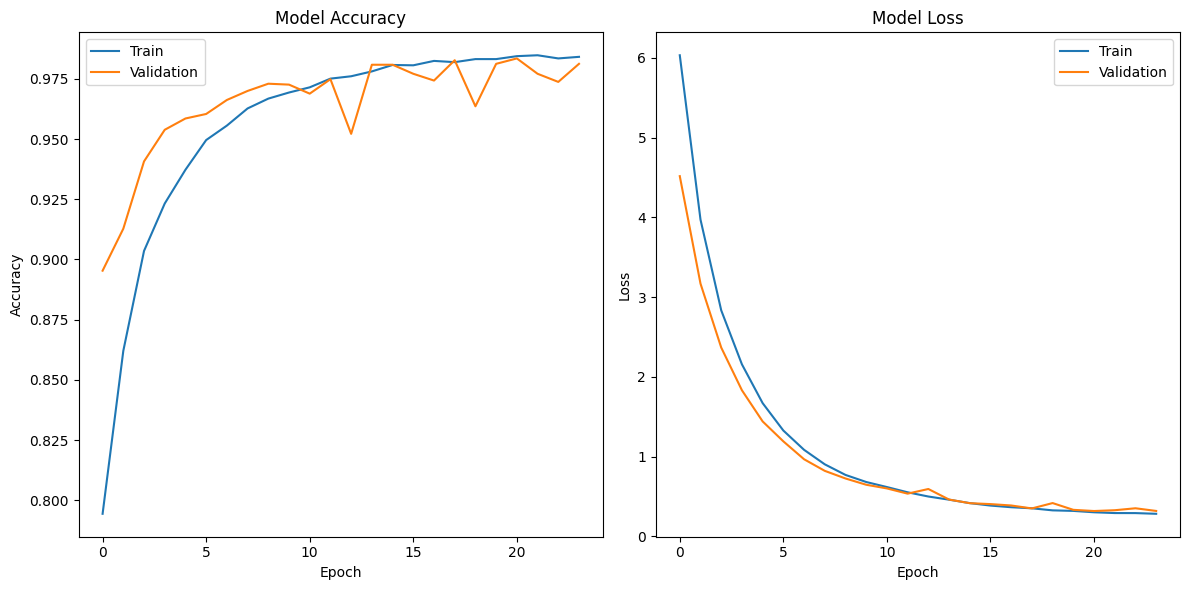

In [ ]:
plot_training_history(history_more_complex_model)

Generally, this model has a higher training accuracy than validation accuracy. Validaton accuracy experienced significant fluctuations since epoch 10. However, it is still no indications of overfitting.

In [ ]:
# Increasing rate
train_rate_mComplex, val_rate_mComplex = calculate_accuracy_increase_rate(history_more_complex_model)
print("Training Accuracy Increase Rate:", train_rate_mComplex)
print("Validation Accuracy Increase Rate:", val_rate_mComplex)

Training Accuracy Increase Rate: 0.008250026599220608
Validation Accuracy Increase Rate: 0.0037346300871475883


The rate of increase for accuracy is calculated above. It is training at a much slower rate than the simple CNN model.

Then, the model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_mComplex, test_accuracy_mComplex = model_more_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_mComplex:.4f}")
print(f"Test Accuracy: {test_accuracy_mComplex:.4f}")

394/394 [==============================] - 18s 45ms/step - loss: 0.5808 - accuracy: 0.9071
Test Loss: 0.5808
Test Accuracy: 0.9071


In [ ]:
# Make predictions on the test data
test_pred_mComplex = model_more_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_mComplex = np.argmax(test_pred_mComplex, axis=1)

# Calculate the precision score
precision_mComplex = precision_score(true_labels, predicted_labels_mComplex, average='weighted')

print(f"Precision Score: {precision_mComplex:.4f}")

394/394 [==============================] - 17s 44ms/step
Precision Score: 0.9162


In [ ]:
# Generate a classification report
class_rep_mComplex = classification_report(true_labels, predicted_labels_mComplex, target_names=class_names)

print("Classification Report:\n", class_rep_mComplex)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       293
           1       0.99      0.98      0.98       293
           2       1.00      0.99      0.99       293
           3       0.96      0.96      0.96       293
           4       1.00      0.94      0.96       293
           5       1.00      0.99      0.99       293
           6       1.00      0.98      0.99       293
           7       0.93      1.00      0.96       293
           8       0.88      0.97      0.93       293
           9       0.98      1.00      0.99       293
          10       0.95      0.92      0.94       293
          11       0.67      0.99      0.80       293
          12       0.96      0.99      0.97       293
          13       0.65      0.91      0.76       293
          14       0.95      0.82      0.88       293
          15       0.97      0.88      0.92       293
          16       0.61      0.76      0.68       293
   

Although the model is performing much better in training data, the performance on test data **very similar** to the previous model. **Althernative model is recommended** as this is learning at a slower rate with more computational power needed.

<h2> Model 4: Even more complex CNN with regularization and more layers</h2>


As the previous model not performing well, an attempt has been made to add more layers to the model so that it could potentially allow a **more complexed model** with less likelihood of overfitting, at a cost of **increased training time**.

In [ ]:
# Define a more complex CNN architecture
input_layer = Input(shape=(128, 128, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

# Add another dense layer with dropout
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_modified = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_modified.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

The above model is revised from all previous models. It added more omore set of dense layers and dropout layers with regularization. It also had a lower learning rate.

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 50
history_modified_model = model_modified.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 55s 78ms/step - loss: 14.4023 - accuracy: 0.2756 - val_loss: 8.6471 - val_accuracy: 0.6772
Epoch 2/50
667/667 [==============================] - 50s 74ms/step - loss: 7.4680 - accuracy: 0.5992 - val_loss: 5.3508 - val_accuracy: 0.8462
Epoch 3/50
667/667 [==============================] - 52s 78ms/step - loss: 5.0092 - accuracy: 0.7397 - val_loss: 3.8478 - val_accuracy: 0.8877
Epoch 4/50
667/667 [==============================] - 50s 75ms/step - loss: 3.6029 - accuracy: 0.8224 - val_loss: 2.8122 - val_accuracy: 0.9353
Epoch 5/50
667/667 [==============================] - 50s 74ms/step - loss: 2.6577 - accuracy: 0.8780 - val_loss: 2.1057 - val_accuracy: 0.9571
Epoch 6/50
667/667 [==============================] - 53s 79ms/step - loss: 2.0043 - accuracy: 0.9114 - val_loss: 1.6206 - val_accuracy: 0.9653
Epoch 7/50
667/667 [==============================] - 48s 72ms/step - loss: 1.5403 - accuracy: 0.9347 - val_loss: 1.2847 - val_accuracy

The training stopped at **epoch 31** as the model started overfitting (shown by the validation loss). This happend 7 epoch after the previous model. The training accuracy and validation accuracy graph are shown below. It was noted that the **training accuracy** and the **validation accuracy** are both **still very high**.

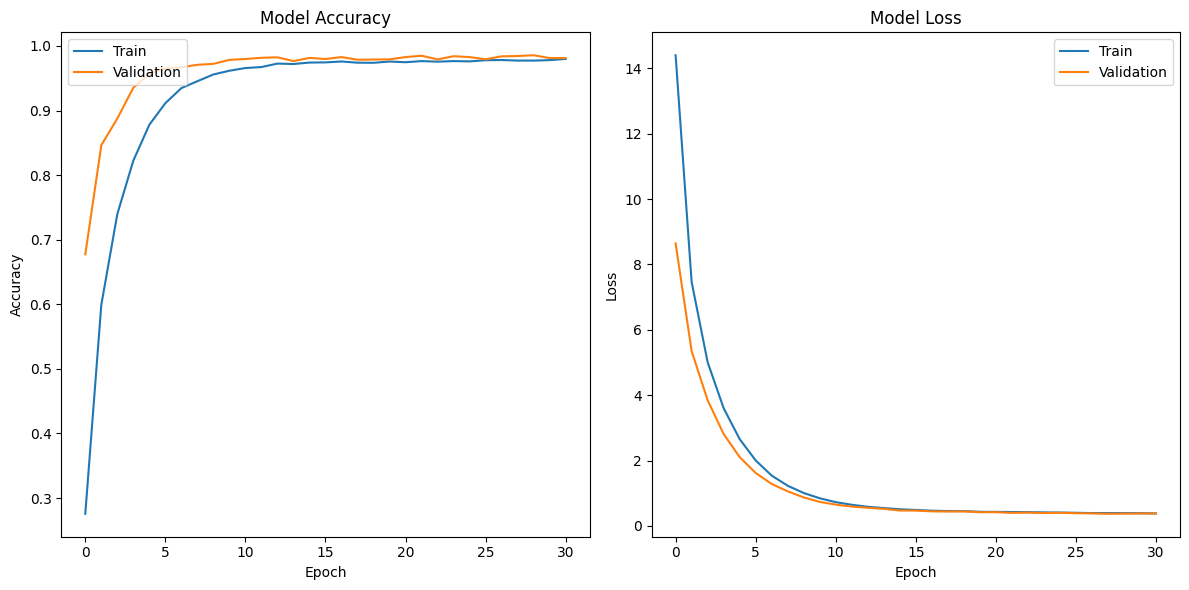

In [ ]:
plot_training_history(history_modified_model)

This model has a similar training accuracy than validation accuracy. UnLike the previous model, validation accuracy did **not experienced significant fluctuations**. The model is thus much more **stable**. Moreover, it is still no indications of overfitting.

  The model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_mComplex, test_accuracy_mComplex = model_modified.evaluate(test_generator)

print(f"Test Loss: {test_loss_mComplex:.4f}")
print(f"Test Accuracy: {test_accuracy_mComplex:.4f}")

394/394 [==============================] - 17s 44ms/step - loss: 0.6082 - accuracy: 0.9175
Test Loss: 0.6082
Test Accuracy: 0.9175


In [ ]:
# Make predictions on the test data
test_pred_modified = model_modified.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_modified = np.argmax(test_pred_modified, axis=1)

# Calculate the precision score
precision_modified = precision_score(true_labels, predicted_labels_modified, average='weighted')

print(f"Precision Score: {precision_modified:.4f}")

394/394 [==============================] - 16s 42ms/step
Precision Score: 0.9210


After this adjustment, the new model did **not perform better** than the previous model. Thus, the exploration of model structure is concluded.

The project will more on to saving this model and training of other models.

<h1> 7.3 Saving the model</h1>

The raw predictions, training history, and model are saved below. They were all saved to google drive for reusing and analysis in the future.

In [ ]:
# Define the file path where you want to save the raw predictions
save_path = "best_test_predictions_CNN_RRDB.npy"

# Save the raw predictions to the specified file
np.save(save_path, test_pred_modified)

print(f"Raw predictions saved to '{save_path}'.")

Raw predictions saved to 'best_test_predictions_CNN_RRDB.npy'.


In [ ]:
model_modified.save("final_CNN_model_RRDB.keras")

In [ ]:
def save_training_history(history, filename):
    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Save the DataFrame to a CSV file
    history_df.to_csv(filename, index=False)

    # Print the first few rows of the history DataFrame
    print(history_df.head())

In [ ]:
save_training_history(history_simpleCNN, 'training_history_simpleCNN_RRDB.csv')
save_training_history(history_modified_model, 'training_history_complexCNN_RRDB.csv')

       loss  accuracy  val_loss  val_accuracy
0  2.545618  0.303498  0.966991      0.746999
1  1.143042  0.638644  0.557162      0.842273
2  0.836582  0.726838  0.321065      0.910728
3  0.664109  0.780476  0.280557      0.923856
4  0.559052  0.812734  0.236826      0.936609
        loss  accuracy  val_loss  val_accuracy
0  14.402254  0.275647  8.647143      0.677232
1   7.467972  0.599165  5.350805      0.846212
2   5.009227  0.739685  3.847840      0.887659
3   3.602857  0.822393  2.812239      0.935296
4   2.657746  0.877954  2.105672      0.957052


In [ ]:
import shutil
import os

# Define the destination directory in Google Drive
dest_dir = 'drive/MyDrive/final/training_models/CNN/'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Define the source paths
src_paths = [
    'final_CNN_model_RRDB.keras',
    'training_history_simpleCNN_RRDB.csv',
    'training_history_complexCNN_RRDB.csv',
    'best_test_predictions_CNN_RRDB.npy'
]

# Copy files to Google Drive
for src_path in src_paths:
    shutil.copy(src_path, dest_dir)

print("Files copied to Google Drive successfully.")

Files copied to Google Drive successfully.
